In [1]:
# Number of Autopilot candidates to evaluate and run batch transform jobs.
# Make sure that you do not put a larger TOP_N_CANDIDATES than the Batch Transform limit for ml.m5.xlarge instances in your account.
TOP_N_CANDIDATES = 1

In [ ]:
# to get the latest sagemaker python sdk
!pip install -U sagemaker

In [6]:
import sagemaker
import boto3
from sagemaker import get_execution_role

print(sagemaker.__version__)
region = boto3.Session().region_name
session = sagemaker.Session()
role = get_execution_role()

bucket = 'rodzanto2020ml'
prefix = 'mediaset/train/all'

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

2.33.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import AutoML
from time import gmtime, strftime, sleep
from pprint import pprint
import json
import io
from urllib.parse import urlparse
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, average_precision_score, precision_score, recall_score
import matplotlib.pyplot as plt

## Training

In [4]:
from sagemaker import AutoML
from time import gmtime, strftime, sleep

timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
target_attribute_name = 'target_edad'
base_job_name = 'automl-ms-all-sdk-' + timestamp_suffix

automl = AutoML(role=role,
                target_attribute_name=target_attribute_name,
                base_job_name=base_job_name,
                sagemaker_session=session,
                max_candidates=10)

In [8]:
train_file = 's3://{}/{}/'.format(bucket, prefix)
print(train_file)

automl.fit(train_file, job_name=base_job_name, wait=False, logs=False)

s3://rodzanto2020ml/mediaset/train/all/


In [ ]:
print ('JobStatus - Secondary Status')
print('------------------------------')

describe_response = automl.describe_auto_ml_job()
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = automl.describe_auto_ml_job()
    job_run_status = describe_response['AutoMLJobStatus']
    
    print(describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - Analyzing

In [10]:
best_candidate = automl.describe_auto_ml_job()['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
pprint(best_candidate)
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

{'CandidateName': 'tuning-job-1-13737ab000504d778a-002-5a3bb8d0',
 'CandidateProperties': {'CandidateArtifactLocations': {'Explainability': 's3://sagemaker-eu-west-1-889960878219/automl-ms-all-sdk-21-07-37-14/documentation/explainability/output'}},
 'CandidateStatus': 'Completed',
 'CandidateSteps': [{'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:889960878219:processing-job/db-1-c23a2d1e738440869b769a3b7297f30e0f85cd1944184ef38c13982730',
                     'CandidateStepName': 'db-1-c23a2d1e738440869b769a3b7297f30e0f85cd1944184ef38c13982730',
                     'CandidateStepType': 'AWS::SageMaker::ProcessingJob'},
                    {'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:889960878219:training-job/automl-ms--dpp3-1-e4bfacc0f1a94f409fe1aba79086bf6a3a82e44c9b804',
                     'CandidateStepName': 'automl-ms--dpp3-1-e4bfacc0f1a94f409fe1aba79086bf6a3a82e44c9b804',
                     'CandidateStepType': 'AWS::SageMaker::TrainingJob'},
                    {'Ca

In [11]:
candidates = automl.list_candidates(sort_by='FinalObjectiveMetricValue',
                                    sort_order='Descending',
                                    max_results=TOP_N_CANDIDATES)

for candidate in candidates:
    print("Candidate name: ", candidate['CandidateName'])
    print("Objective metric name: ", candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
    print("Objective metric value: ", candidate['FinalAutoMLJobObjectiveMetric']['Value'])
    print('\n')

Candidate name:  tuning-job-1-13737ab000504d778a-002-5a3bb8d0
Objective metric name:  validation:accuracy
Objective metric value:  0.9995099902153015




### Inference

In [24]:

data = pd.read_csv('./file7.csv', header=None)
pd.set_option('display.max_columns', 50)
#data
data.columns = ["obfs_bkuuid", "gigya_uid", "target_sexo", "target_edad", "target", "gdpr", "x1022109", "x1022111", "x1022140", "x1022141", "x1022142", "x1022143", "x1022144", "x1040018", "x1040020", "x1040022", "x1040023", "x1040030", "x1040031", "x1040032", "x1040033", "x1040034", "x1040035", "x1040036", "x1040037", "x1040038", "x1040071", "x1040072", "x1040073", "x1040075", "x1040215", "x1040329", "x1040330", "x1040360", "x1040367", "x1040368", "x1040369", "x1040386", "x1040387", "x1040474", "x1040475", "x1040476", "x1040485", "x1040487", "x1040488", "x1041286", "x1041288", "x1042276", "x1044887", "x1044895", "x1046592", "x1047978", "x1052919", "x1058558", "x1058559", "x1060974", "x1060975", "x1060976", "x1060981", "x1067940", "x1071645", "x1071712", "x1076376", "x1076377", "x1077184", "x1077185", "x1077186", "x1077187", "x1079675", "x1079677", "x1079678", "x1079679", "x1079680", "x1079681", "x1079683", "x1079684", "x1079685", "x1079686", "x1079687", "x1079688", "x1079689", "x1079691", "x1079692", "x1079693", "x1079694", "x1079695", "x1079696", "x1079745", "x1079746", "x1079747", "x1079748", "x1079750", "x1079751", "x1079752", "x1079779", "x1079780", "x1088678", "x1088679", "x1088742", "x1089436", "x1089453", "x1089455", "x1089514", "x1089607", "x1089608", "x1089609", "x1089610", "x1090993", "x1091000", "x1091003", "x1091009", "x1091039", "x1091239", "x1091241", "x1093443", "x1094182", "x1096504", "x1100105", "x1102804", "x1109705", "x1109706", "x1109707", "x1109710", "x1109720", "x1109721", "x1113785", "x1113786", "x1125651", "x1126550", "x1126551", "x1126552", "x1126553", "x1126554", "x1126555", "x1126556", "x1126557", "x1128200", "x1128201", "x1128202", "x1128203", "x1128204", "x1128206", "x1148707", "x1148712", "x1148754", "x1148759", "x1148877", "x1149103", "x1151398", "x1151399", "x1151400", "x1159656", "x1159664", "x1159669", "x1159671", "x1159672", "x1169831", "x1169832", "x1169834", "x1169835", "x1169843", "x1169866", "x1169867", "x1169868", "x1169869", "x1169870", "x1169871", "x1171944", "x1172122", "x1174183", "x1174185", "x1174204", "x1174205", "x1174206", "x1174207", "x1174251", "x1174253", "x1174343", "x1174880", "x1176308", "x1176309", "x1176310", "x1176311", "x1176312", "x1176313", "x1176314", "x1176315", "x1176316", "x1176317", "x1176318", "x1176319", "x1176320", "x1176321", "x1176322", "x1176323", "x1176324", "x1176325", "x1176326", "x1176327", "x1176328", "x1176329", "x1176330", "x1176331", "x1176333", "x1176334", "x1176335", "x1176336", "x1176337", "x1176338", "x1176339", "x1176344", "x1176345", "x1176347", "x1176354", "x1176356", "x1176358", "x1176359", "x1176360", "x1176361", "x1176362", "x1176363", "x1176364", "x1176365", "x1176366", "x1176367", "x1176369", "x1176370", "x1176371", "x1176372", "x1176373", "x1176375", "x1176376", "x1176377", "x1176378", "x1176379", "x1176380", "x1176381", "x1176382", "x1176383", "x1176384", "x1176385", "x1176386", "x1176387", "x1176388", "x1176389", "x1176390", "x1176391", "x1176392", "x1176393", "x1176394", "x1176395", "x1176396", "x1176397", "x1176398", "x1176399", "x1176400", "x1176401", "x1176402", "x1176403", "x1176404", "x1176405", "x1176406", "x1176407", "x1176408", "x1176409", "x1176410", "x1176411", "x1176412", "x1176413", "x1176414", "x1176415", "x1176416", "x1176417", "x1176418", "x1176419", "x1176420", "x1176421", "x1176422", "x1176423", "x1176424", "x1176425", "x1176426", "x1176427", "x1176428", "x1176429", "x1176430", "x1176431", "x1176432", "x1176433", "x1176434", "x1176435", "x1176436", "x1176437", "x1176438", "x1176439", "x1176440", "x1176441", "x1176442", "x1176443", "x1176444", "x1176445", "x1176446", "x1176448", "x1176449", "x1176450", "x1176451", "x1176452", "x1176453", "x1176454", "x1176455", "x1176456", "x1176457", "x1176458", "x1176459", "x1176460", "x1176461", "x1176462", "x1176463", "x1176464", "x1176465", "x1176466", "x1176467", "x1176468", "x1176469", "x1176470", "x1176471", "x1176472", "x1176473", "x1176474", "x1176475", "x1176476", "x1176477", "x1176478", "x1176479", "x1176480", "x1176481", "x1176482", "x1176483", "x1176484", "x1176485", "x1176486", "x1176487", "x1176488", "x1176489", "x1176490", "x1176491", "x1176492", "x1176493", "x1176494", "x1176495", "x1176496", "x1176497", "x1176498", "x1177569", "x1183612", "x1187202", "x1187203", "x1187223", "x1187230", "x1187261", "x1187270", "x1187290", "x1187293", "x1187348", "x1187349", "x1187354", "x1187356", "x1187358", "x1187360", "x1187362", "x1187365", "x1187366", "x1188121", "x1188123", "x1188126", "x1188127", "x1188128", "x1188137", "x1188144", "x1188147", "x1188150", "x1188194", "x1188261", "x1188273", "x1188274", "x1188276", "x1189015", "x1189112", "x1189120", "x1189147", "x1189148", "x1189439", "x1189450", "x1189622", "x1189623", "x1189624", "x1189625", "x1189628", "x1189629", "x1189630", "x1189632", "x1189633", "x1189635", "x1189636", "x1189637", "x1189638", "x1189639", "x1189640", "x1189641", "x1189642", "x1189643", "x1189645", "x1189646", "x1189647", "x1189648", "x1189651", "x1189652", "x1189653", "x1189660", "x1189662", "x1189663", "x1189665", "x1189757", "x1189979", "x1189981", "x1190035", "x1190149", "x1194682", "x1195103", "x1195105", "x1195106", "x1195107", "x1195108", "x1195109", "x1195122", "x1195130", "x1195131", "x1195132", "x1195133", "x1195135", "x1195136", "x1195137", "x1195138", "x1195139", "x1195141", "x1195144", "x1195145", "x1195146", "x1195147", "x1195148", "x1195149", "x1195150", "x1195151", "x1195152", "x1195153", "x1195171", "x1195179", "x1195180", "x1195181", "x1195184", "x1209396", "x1210058", "x1210084", "x1210085", "x1210295", "x1213402", "x1213426", "x1213480", "x1213626", "x1213627", "x1213630", "x1215553", "x1215554", "x1215555", "x1215575", "x1215576", "x1215618", "x1215629", "x1215709", "x1215789", "x1215792", "x1215794", "x1215801", "x1218315", "x1218319", "x1218361", "x1218375", "x1233577", "x1233581", "x1233583", "x1233586", "x1233779", "x1233813", "x1233818", "x1239513", "x1239806", "x1239807", "x1239808", "x1239809", "x1239821", "x1239834", "x1240605", "x1240619", "x1240620", "x1240621", "x1240622", "x1240623", "x1240624", "x1240625", "x1240626", "x1240628", "x1240658", "x1240692", "x1240792", "x1240810", "x1240841", "x1240842", "x1240868", "x1240869", "x1241105", "x1241148", "x1241207", "x1241216", "x1241223", "x1241234", "x1241247", "x1241248", "x1241253", "x1241254", "x1241259", "x1241265", "x1241270", "x1241271", "x1241272", "x1241273", "x1241274", "x1241275", "x1241283", "x1241297", "x1241317", "x1241321", "x1241326", "x1241492", "x1241497", "x1241577", "x1241702", "x1241719", "x1243229", "x1243232", "x1243233", "x1243234", "x1243349", "x1243820", "x1243827", "x1243831", "x1243921", "x1243931", "x1245427", "x1245428", "x1245429", "x1245430", "x1245431", "x1245432", "x1245434", "x1245448", "x1245456", "x1245457", "x1245471", "x1245472", "x1245473", "x1245474", "x1245476", "x1245477", "x1245798", "x1247531", "x1247541", "x1247568", "x1248085", "x1265992", "x1265993", "x1265994", "x1265995", "x1265996", "x1265997", "x1265998", "x1265999", "x1266000", "x1266002", "x1266003", "x1266004", "x1266005", "x1266006", "x1266007", "x1266008", "x1266009", "x1266010", "x1266011", "x1266016", "x1266021", "x1266023", "x1266024", "x1266025", "x1266026", "x1266027", "x1266028", "x1266029", "x1266030", "x1266031", "x1266032", "x1266033", "x1266034", "x1266036", "x1266037", "x1266038", "x1266039", "x1266040", "x1266041", "x1266042", "x1266043", "x1266044", "x1266045", "x1266046", "x1266047", "x1266048", "x1266049", "x1266050", "x1266056", "x1266939", "x1266941", "x1266944", "x1266945", "x1266946", "x1266947", "x1266948", "x1266949", "x1266950", "x1266951", "x1266952", "x1266953", "x1266954", "x1266955", "x1266956", "x1266957", "x1266958", "x1266959", "x1266960", "x1266961", "x1266962", "x1266963", "x1266964", "x1266965", "x1266966", "x1266967", "x1270453", "x1270455", "x1270458", "x1270460", "x1270461", "x1270462", "x1270463", "x1270464", "x1270465", "x1270466", "x1270467", "x1270469", "x1270478", "x1270479", "x1270480", "x1270485", "x1270491", "x1270494", "x1270495", "x1270496", "x1270497", "x1271234", "x1271235", "x1271241", "x1271242", "x1271243", "x1271245", "x1271258", "x1271259", "x1271261", "x1271263", "x1271264", "x1271265", "x1271267", "x1271270", "x1271271", "x1271272", "x1271273", "x1271274", "x1271275", "x1271276", "x1271277", "x1271278", "x1271283", "x1271284", "x1271285", "x1271286", "x1271287", "x1271288", "x1271289", "x1271290", "x1271296", "x1271297", "x1271298", "x1271312", "x1271313", "x1271314", "x1271317", "x1271318", "x1271319", "x1271357", "x1271358", "x1271359", "x1271360", "x1271361", "x1271362", "x1271364", "x1271365", "x1271366", "x1271368", "x1271370", "x1271371", "x1271372", "x1271373", "x1271374", "x1271375", "x1271382", "x1271383", "x1271385", "x1271386", "x1271387", "x1271388", "x1271389", "x1271393", "x1271395", "x1271396", "x1279917", "x1279924", "x1279930", "x1279943", "x1279955", "x1279961", "x1280008", "x1280011", "x1280012", "x1280018", "x1280022", "x1280050", "x1280060", "x1280069", "x1280076", "x1280077", "x1280080", "x1280084", "x1281051", "x1281052", "x1281053", "x1281054", "x1281055", "x1281056", "x1281057", "x1281058", "x1281059", "x1281060", "x1281079", "x1281082", "x1281085", "x1283061", "x1283065", "x1283131", "x1293053", "x1293054", "x1293056", "x1293057", "x1293058", "x1293059", "x1293060", "x1293061", "x1293062", "x1293063", "x1293064", "x1293065", "x1293066", "x1293067", "x1293068", "x1293069", "x1293070", "x1293071", "x1293072", "x1293073", "x1293074", "x1293075", "x1293076", "x1293077", "x1293102", "x1293103", "x1293104", "x1293105", "x1293106", "x1293107", "x1293108", "x1293109", "x1293110", "x1293111", "x1293119", "x1293120", "x1293121", "x1293122", "x1293123", "x1293124", "x1293125", "x1293126", "x1293127", "x1293128", "x1293176", "x1295861", "x1307346", "x1307348", "x1309465", "x1314357", "x1316183", "x1316211", "x1316217", "x1317646", "x1318244", "x1323092", "x1323098", "x1323099", "x1323103", "x1323104", "x1323107", "x1323109", "x1336979", "x1336980", "x1336997", "x1338578", "x1338579", "x1338582", "x1338585", "x1342189", "x1342964", "x1342965", "x1342972", "x1342976", "x1342977", "x1342982", "x1342983", "x1342991", "x1342992", "x1343314", "x1343930", "x1343955", "x1352478", "x1355015", "x1357533", "x1374845", "x1374853", "x1374859", "x1374864", "x1374906", "x1374907", "x1374910", "x1374911", "x1374913", "x1374917", "x1374920", "x1374923", "x1374925", "x1374929", "x1374936", "x1374941", "x1374943", "x1374945", "x1374946", "x1374947", "x1374951", "x1374952", "x1374954", "x1374955", "x1374964", "x1374965", "x1374966", "x1374967", "x1374970", "x1374971", "x1374972", "x1374973", "x1374975", "x1374976", "x1374978", "x1375011", "x1375460", "x1375468", "x1375469", "x1375470", "x1375471", "x1375479", "x1375480", "x1375481", "x1375482", "x1375485", "x1375490", "x1375492", "x1375493", "x1375499", "x1375500", "x1375502", "x1375504", "x1375505", "x1375508", "x1377078", "x1377094", "x1377097", "x1377105", "x1377129", "x1377130", "x1377131", "x1377133", "x1377134", "x1377135", "x1377137", "x1377138", "x1377140", "x1377141", "x1377142", "x1377143", "x1377146", "x1382862", "x1388622", "x1388663", "x1388674", "x1388676", "x1388724", "x1389462", "x1389463", "x1389464", "x1389477", "x1389478", "x1389489", "x1389490", "x1389491", "x1389492", "x1389493", "x1389494", "x1389495", "x1389496", "x1389497", "x1389499", "x1389500", "x1389501", "x1389502", "x1389503", "x1389504", "x1389505", "x1389506", "x1389507", "x1389508", "x1389509", "x1389516", "x1389518", "x1389525", "x1389526", "x1389550", "x1389859", "x1389883", "x1389884", "x1389889", "x1389890", "x1389905", "x1389906", "x1389907", "x1389909", "x1389910", "x1389911", "x1389913", "x1389914", "x1389915", "x1389916", "x1389917", "x1389918", "x1389919", "x1389920", "x1389921", "x1389923", "x1389924", "x1389925", "x1389926", "x1389927", "x1392218", "x1392243", "x1392245", "x1392246", "x1392247", "x1392294", "x1393115", "x1393118", "x1393124", "x1393125", "x1393126", "x1393127", "x1393128", "x1393129", "x1393130", "x1393131", "x1393132", "x1393133", "x1393134", "x1393135", "x1393138", "x1393139", "x1393140", "x1393141", "x1393142", "x1393144", "x1395757", "x1395762", "x1395767", "x1395968", "x1395969", "x1395971", "x1395973", "x1395974", "x1396038", "x1396040", "x1396048", "x1396049", "x1396061", "x1396363", "x1396364", "x1396365", "x1396367", "x1396372", "x1396373", "x1396375", "x1396377", "x1396380", "x1396385", "x1396386", "x1396396", "x1396397", "x1396398", "x1396399", "x1396400", "x1396401", "x1396402", "x1396405", "x1396406", "x1396407", "x1396408", "x1396409", "x1396410", "x1396411", "x1396412", "x1396424", "x1396425", "x1396426", "x1396438", "x1396439", "x1396440", "x1396441", "x1396442", "x1396443", "x1396450", "x1396452", "x1396459", "x1396463", "x1396464", "x1396465", "x1396466", "x1396468", "x1396469", "x1396939", "x1397895", "x1397903", "x1397930", "x1397935", "x1397936", "x1397937", "x1397939", "x1397940", "x1397941", "x1397947", "x1398540", "x1398593", "x1398598", "x1398599", "x1398608", "x1398609", "x1398610", "x1398611", "x1398612", "x1398613", "x1398614", "x1398615", "x1398616", "x1398617", "x1398618", "x1398619", "x1398623", "x1398624", "x1398625", "x1398626", "x1398627", "x1398628", "x1398629", "x1398630", "x1399345", "x1399346", "x1399347", "x1399348", "x1399349", "x1399350", "x1399351", "x1399353", "x1399355", "x1399357", "x1399358", "x1399359", "x1399360", "x1399362", "x1399363", "x1399364", "x1399365", "x1399366", "x1399367", "x1399370", "x1399374", "x1399375", "x1399441", "x1399447", "x1399451", "x1399454", "x1399456", "x1399459", "x1399460", "x1399461", "x1399462", "x1399465", "x1399467", "x1399468", "x1399472", "x1399485", "x1399489", "x1399491", "x1401150", "x1401151", "x1401152", "x1401153", "x1401154", "x1401155", "x1401158", "x1401159", "x1401160", "x1401161", "x1401162", "x1401164", "x1401166", "x1401167", "x1401168", "x1401169", "x1401847", "x1401848", "x1401859", "x1401872", "x1401873", "x1401874", "x1401875", "x1401876", "x1401885", "x1401887", "x1401889", "x1401895", "x1401896", "x1401898", "x1401910", "x1401912", "x1401915", "x1401950", "x1401953", "x1401956", "x1401957", "x1401958", "x1401959", "x1401960", "x1401961", "x1401962", "x1401963", "x1401968", "x1401970", "x1401973", "x1401974", "x1401975", "x1401978", "x1401979", "x1401981", "x1401982", "x1401983", "x1401984", "x1401985", "x1401986", "x1401989", "x1402913", "x1404630", "x1404634", "x1404642", "x1404693", "x1404698", "x1404699", "x1404705", "x1404706", "x1404707", "x1404708", "x1405464", "x1405465", "x1405485", "x1405487", "x1405489", "x1405499", "x1405507", "x1405511", "x1405512", "x1405513", "x1405773", "x1405774", "x1405775", "x1405849", "x1405854", "x1405855", "x1405856", "x1405857", "x1405858", "x1405860", "x1405861", "x1405870", "x1405873", "x1405874", "x1405877", "x1405879", "x1405881", "x1405882", "x1405883", "x1405887", "x1405903", "x1405912", "x1405913", "x1405914", "x1405915", "x1405916", "x1405917", "x1405918", "x1405919", "x1405920", "x1405921", "x1405922", "x1405923", "x1405925", "x1405926", "x1405927", "x1405928", "x1405929", "x1405930", "x1405931", "x1405936", "x1405937", "x1405938", "x1407307", "x1407311", "x1407312", "x1407315", "x1407850", "x1407853", "x1407854", "x1407855", "x1407856", "x1407857", "x1407858", "x1407859", "x1407861", "x1407862", "x1407874", "x1407876", "x1407877", "x1407878", "x1407879", "x1407880", "x1407881", "x1407882", "x1407883", "x1407884", "x1407885", "x1407887", "x1407888", "x1407889", "x1407891", "x1407892", "x1407893", "x1407895", "x1407896", "x1407897", "x1407898", "x1407903", "x1407907", "x1407908", "x1407909", "x1407910", "x1407911", "x1407912", "x1407913", "x1408550", "x1408870", "x1408871", "x1408872", "x1408875", "x1408876", "x1408877", "x1408878", "x1408886", "x1408887", "x1408888", "x1408889", "x1408890", "x1408891", "x1408892", "x1408893", "x1408895", "x1408896", "x1408897", "x1408899", "x1408901", "x1408902", "x1408903", "x1408904", "x1408905", "x1408908", "x1408910", "x1408912", "x1408913", "x1408916", "x1408917", "x1408918", "x1408919", "x1408920", "x1408921", "x1408924", "x1408925", "x1408926", "x1408927", "x1408928", "x1408930", "x1408932", "x1410731", "x1410742", "x1410743", "x1410744", "x1410747", "x1410748", "x1410749", "x1410750", "x1410751", "x1410752", "x1410753", "x1410758", "x1410759", "x1410760", "x1410761", "x1410763", "x1410764", "x1410765", "x1410766", "x1410774", "x1410793", "x1410794", "x1410795", "x1410802", "x1410813", "x1410886", "x1410888", "x1410917", "x1410926", "x1410928", "x1410949", "x1410950", "x1410951", "x1410952", "x1410953", "x1410959", "x1410960", "x1410961", "x1410962", "x1410963", "x1410966", "x1410968", "x1410970", "x1410971", "x1410973", "x1410974", "x1410975", "x1410976", "x1410984", "x1411031", "x1411042", "x1411043", "x1411044", "x1411045", "x1411046", "x1411047", "x1411051", "x1411081", "x1411083", "x1411086", "x1411088", "x1411089", "x1411090", "x1411091", "x1411103", "x1411104", "x1411105", "x1411109", "x1411110", "x1411123", "x1411125", "x1411126", "x1411128", "x1411129", "x1411132", "x1411133", "x1411136", "x1411137", "x1411142", "x1411143", "x1415346", "x1415877", "x1415880", "x1415887", "x1415889", "x1415892", "x1417734", "x1428362", "x1435760", "x1435762", "x1435764", "x1435775", "x1435783", "x1435786", "x1435788", "x1435791", "x1435793", "x1435794", "x1435798", "x1435801", "x1435813", "x1435814", "x1435815", "x1435818", "x1435821", "x1435823", "x1435824", "x1435825", "x1435831", "x1435834", "x1435849", "x1435850", "x1436065", "x1436108", "x1436113", "x1436115", "x1436117", "x1436130", "x1452115", "x1452116", "x1452120", "x1452121", "x1452122", "x1452123", "x1469875", "x1489914", "x1491189", "x1491190", "x1491191", "x1491192", "x1491193", "x1491194", "x1491195", "x1491196", "x1491197", "x1491199", "x1491200", "x1491201", "x1491202", "x1491203", "x1491204", "x1491205", "x1491206", "x1491208", "x1491209", "x1491210", "x1491214", "x1491215", "x1491217", "x1491218", "x1491219", "x1491220", "x1491221", "x1491222", "x1491223", "x1491225", "x1491226", "x1491227", "x1492177", "x1492178", "x1492179", "x1492180", "x1492181", "x1492182", "x1492186", "x1492188", "x1492189", "x1492190", "x1492192", "x1492193", "x1493332", "x1493925", "x1495784", "x1495785", "x1495786", "x1495787", "x1495788", "x1495789", "x1495790", "x1495791", "x1495792", "x1496278", "x1496282", "x1496283", "x1496300", "x1496303", "x1496304", "x1496344", "x1496407", "x1508359", "x1508412", "x1509606", "x1509607", "x1509610", "x1509611", "x1509615", "x1509616", "x1509617", "x1509632", "x1509633", "x1509634", "x1509635", "x1509637", "x1509638", "x1509639", "x1510967", "x1510973", "x1510977", "x1512806", "x1512807", "x1525147", "x1527813", "x1527814", "x1528486", "x1531834", "x1532621", "x1532622", "x1532623", "x1532624", "x1532625", "x1532626", "x1532627", "x1532628", "x1532629", "x1532630", "x1532631", "x1532632", "x1532633", "x1532634", "x1532635", "x1532636", "x1532637", "x1532638", "x1532639", "x1532640", "x1532641", "x1532642", "x1532643", "x1532644", "x1532645", "x1532646", "x1532647", "x1532648", "x1532649", "x1532650", "x1532652", "x1532653", "x1532654", "x1532655", "x1532656", "x1532657", "x1532658", "x1532659", "x1532660", "x1532661", "x1532662", "x1532663", "x1532664", "x1532665", "x1532666", "x1532667", "x1532668", "x1532669", "x1532670", "x1532671", "x1532672", "x1532673", "x1532674", "x1532675", "x1532676", "x1532677", "x1532678", "x1532679", "x1532680", "x1532681", "x1532682", "x1532683", "x1532684", "x1532685", "x1532686", "x1532687", "x1532688", "x1532689", "x1532690", "x1532691", "x1532692", "x1532693", "x1532694", "x1532695", "x1532696", "x1532697", "x1532698", "x1532699", "x1532700", "x1532701", "x1537083", "x1537086", "x1537087", "x1537088", "x1537089", "x1537090", "x1537091", "x1538277", "x1539679", "x1539680", "x1551825", "x1551827", "x1551845", "x1551922", "x1551954", "x1551955", "x1551956", "x1553258", "x1553260", "x1553262", "x1553266", "x1553268", "x1553271", "x1553304", "x1553311", "x1553320", "x1553321", "x1553323", "x1553325", "x1553328", "x1553330", "x1553331", "x1553333", "x1553334", "x1553402", "x1553404", "x1553405", "x1553406", "x1553408", "x1553409", "x1553410", "x1553414", "x1553417", "x1553423", "x1554008", "x1556848", "x1556849", "x1556859", "x1556869", "x1557480", "x1557493", "x1558676", "x1558679", "x1558724", "x1558725", "x1567637", "x1567701", "x1573792", "x1574318", "x1579527", "x1580156", "x1580276", "x1580332", "x1580341", "x1580346", "x1580351", "x1580397", "x1580934", "x1580956", "x1580957", "x1580960", "x1580961", "x1580962", "x1580964", "x1580965", "x1580966", "x1581360", "x1601517", "x1601518", "x1601519", "x1604899", "x1604900", "x1605070", "x1605071", "x1606845", "x1611395", "x1619047", "x1624739", "x1649513", "x1649514", "x1649515", "x1649584", "x1671515", "x1671516", "x676351", "x676352", "x676353", "x676355", "x676356", "x676358", "x676359", "x676360", "x676362", "x676364", "x676365", "x676366", "x676367", "x676368", "x676369", "x676370", "x676371", "x676372", "x676373", "x676374", "x676375", "x676376", "x676377", "x676378", "x676379", "x676380", "x676381", "x676382", "x676385", "x676386", "x676387", "x676389", "x676395", "x676396", "x676401", "x676403", "x676405", "x676407", "x676410", "x676411", "x676412", "x676413", "x676414", "x676415", "x676416", "x676417", "x676418", "x676419", "x676421", "x676422", "x676423", "x676424", "x676425", "x676426", "x676427", "x676428", "x676429", "x676430", "x676431", "x676432", "x676433", "x676434", "x676435", "x676436", "x676437", "x676438", "x676440", "x676441", "x676442", "x676443", "x676444", "x676445", "x676446", "x676447", "x676448", "x676449", "x676450", "x676451", "x676452", "x676453", "x676454", "x676455", "x676456", "x676457", "x676458", "x676459", "x676460", "x676461", "x676463", "x676464", "x676465", "x676467", "x676468", "x676469", "x676470", "x676471", "x676472", "x676473", "x676474", "x676475", "x676476", "x676477", "x676478", "x676479", "x676481", "x676482", "x676483", "x676484", "x676486", "x676487", "x676488", "x676489", "x676490", "x676491", "x676492", "x676493", "x676494", "x676495", "x676496", "x676497", "x676498", "x676499", "x676500", "x676501", "x676502", "x676503", "x676504", "x676505", "x676506", "x676507", "x676508", "x676509", "x676510", "x676511", "x676512", "x676513", "x676514", "x676515", "x676516", "x676517", "x676518", "x676520", "x676521", "x676523", "x676524", "x676525", "x676526", "x676527", "x712337", "x712392", "x712403", "x712445", "x712446", "x712448", "x712449", "x712450", "x721373", "x721374", "x721375", "x721376", "x721377", "x721381", "x721388", "x721389", "x721390", "x721391", "x721392", "x721393", "x721394", "x721395", "x721398", "x721399", "x721400", "x721401", "x721402", "x721403", "x721404", "x721407", "x721408", "x721412", "x721413", "x721415", "x721419", "x721420", "x721430", "x721431", "x721432", "x721434", "x721435", "x721436", "x721437", "x721438", "x721439", "x721440", "x721441", "x721442", "x721444", "x721445", "x724857", "x724859", "x724863", "x724864", "x724867", "x724869", "x724873", "x724877", "x724879", "x724880", "x724881", "x724884", "x724886", "x724887", "x724888", "x724890", "x724891", "x724892", "x724893", "x724894", "x724897", "x724899", "x724903", "x724905", "x724906", "x724907", "x724914", "x724916", "x724917", "x724918", "x724920", "x724921", "x724923", "x725006", "x725009", "x725011", "x725037", "x725058", "x725059", "x725060", "x725061", "x725063", "x725064", "x725066", "x725067", "x725072", "x725074", "x725075", "x725076", "x725079", "x725080", "x725083", "x725084", "x725085", "x725096", "x725097", "x725098", "x725105", "x725106", "x725107", "x725109", "x725112", "x725113", "x725133", "x725134", "x725135", "x725136", "x725138", "x725140", "x725141", "x725142", "x725143", "x725144", "x725145", "x725146", "x725147", "x725148", "x725149", "x725187", "x725188", "x725189", "x725206", "x725207", "x725208", "x725228", "x725229", "x725230", "x725231", "x725233", "x725235", "x725236", "x725237", "x725238", "x725239", "x725240", "x725241", "x725243", "x725244", "x725245", "x725246", "x725247", "x725251", "x725254", "x725256", "x725257", "x725258", "x725260", "x725261", "x725262", "x725264", "x725265", "x725266", "x725283", "x725284", "x725293", "x725294", "x725295", "x725296", "x725297", "x725298", "x725299", "x725301", "x725302", "x725303", "x725304", "x725307", "x725308", "x725309", "x725310", "x725312", "x725313", "x725314", "x725315", "x725316", "x725317", "x725318", "x725319", "x725320", "x725323", "x725324", "x725325", "x725326", "x725328", "x725329", "x725330", "x725332", "x725334", "x725335", "x725336", "x725339", "x725340", "x725341", "x725342", "x725343", "x725345", "x725346", "x725347", "x725348", "x725349", "x725350", "x725353", "x725354", "x725355", "x725356", "x725357", "x725358", "x743493", "x743494", "x743498", "x743535", "x743536", "x743541", "x743542", "x743543", "x743559", "x743561", "x743562", "x743563", "x743568", "x743570", "x743571", "x743572", "x743573", "x743574", "x743578", "x743580", "x743581", "x743582", "x743583", "x743584", "x743585", "x743588", "x743589", "x743602", "x743605", "x743614", "x743619", "x743622", "x743628", "x743631", "x743637", "x743638", "x743641", "x743643", "x803814", "x803815", "x803816", "x803817", "x803818", "x803819", "x803820", "x803821", "x803822", "x803823", "x822055", "x826365", "x826366", "x826367", "x826368", "x826369", "x826370", "x826371", "x826372", "x826373", "x826374", "x826376", "x826377", "x826378", "x826379", "x826381", "x826382", "x826383", "x826384", "x826385", "x826387", "x826388", "x826389", "x826390", "x826392", "x826393", "x826394", "x826395", "x826399", "x826400", "x826401", "x826402", "x826403", "x826404", "x826405", "x826406", "x826407", "x826408", "x826409", "x826410", "x826412", "x826413", "x826414", "x826416", "x826418", "x826420", "x826421", "x826422", "x826423", "x826424", "x826425", "x826426", "x826427", "x826428", "x826430", "x826431", "x826432", "x826434", "x826435", "x826436", "x826437", "x826438", "x826440", "x826441", "x826442", "x826443", "x826444", "x826445", "x826446", "x826448", "x826449", "x826450", "x826451", "x826452", "x826453", "x826454", "x826455", "x826456", "x826457", "x826458", "x826460", "x826462", "x826464", "x826465", "x826466", "x826488", "x826492", "x826498", "x826500", "x826501", "x826503", "x826504", "x827701", "x827702", "x827703", "x827704", "x827705", "x827707", "x844399", "x844400", "x844401", "x844402", "x844403", "x844406", "x847908", "x847909", "x847922", "x847924", "x847925", "x858062", "x858066", "x858723", "x858724", "x858725", "x858727", "x858728", "x858729", "x858731", "x858987", "x863723", "x863726", "x865295", "x865304", "x865589", "x865590", "x865592", "x865649", "x865651", "x865674", "x865679", "x865681", "x865682", "x865685", "x865698", "x865700", "x865701", "x865703", "x865998", "x868350", "x868506", "x868507", "x868508", "x868509", "x868512", "x868513", "x868514", "x868515", "x868516", "x868517", "x868518", "x868519", "x868520", "x868521", "x868523", "x868524", "x868525", "x868526", "x868535", "x868536", "x868537", "x868538", "x868539", "x868540", "x868541", "x868542", "x868543", "x868545", "x868546", "x868547", "x868548", "x868549", "x868550", "x868551", "x868552", "x868553", "x868554", "x868556", "x868557", "x868558", "x868559", "x868560", "x868563", "x868566", "x868567", "x868568", "x868569", "x868570", "x868571", "x868572", "x868573", "x868574", "x868575", "x868576", "x868577", "x868578", "x868580", "x868581", "x868583", "x868586", "x868587", "x868588", "x868589", "x868591", "x868592", "x868593", "x868594", "x868595", "x868596", "x868597", "x868598", "x868599", "x868830", "x868832", "x868837", "x868904", "x868907", "x868908", "x868972", "x868973", "x868974", "x868979", "x868980", "x868981", "x868982", "x868983", "x868984", "x868985", "x868986", "x868987", "x868988", "x868989", "x868990", "x868991", "x868992", "x868993", "x868994", "x869081", "x869082", "x869083", "x869084", "x869085", "x869086", "x869087", "x869088", "x869089", "x869090", "x869091", "x869092", "x869093", "x869096", "x869097", "x869098", "x869099", "x869100", "x869101", "x869102", "x869103", "x869104", "x869105", "x869107", "x869108", "x869109", "x869110", "x869111", "x869112", "x869113", "x869114", "x869116", "x869117", "x869118", "x869119", "x869120", "x869121", "x869122", "x869123", "x869124", "x869125", "x869126", "x869127", "x869128", "x869129", "x869130", "x869133", "x869135", "x869767", "x869769", "x869770", "x869776", "x869777", "x869778", "x869780", "x869781", "x869789", "x869829", "x869831", "x869832", "x869837", "x869839", "x870799", "x870800", "x870801", "x870803", "x870829", "x870831", "x870832", "x870837", "x870839", "x871140", "x871141", "x872774", "x872789", "x872798", "x872800", "x872805", "x872806", "x872815", "x872816", "x872817", "x873303", "x873304", "x873305", "x873306", "x873307", "x873308", "x873309", "x873310", "x873311", "x873312", "x873313", "x873314", "x873315", "x873317", "x873319", "x873322", "x873325", "x873326", "x873327", "x873328", "x873330", "x873331", "x873332", "x873333", "x873334", "x873336", "x873338", "x873340", "x873344", "x873345", "x873346", "x873351", "x873353", "x873354", "x873355", "x873356", "x873357", "x873358", "x873359", "x873360", "x873361", "x873362", "x873363", "x873364", "x873365", "x873369", "x873371", "x873373", "x873377", "x873378", "x873379", "x873381", "x873383", "x873385", "x873386", "x873387", "x873389", "x873390", "x873391", "x873392", "x873394", "x873398", "x873399", "x873400", "x873401", "x873404", "x873405", "x873406", "x873407", "x873408", "x873409", "x873410", "x873411", "x873414", "x873497", "x873498", "x873499", "x873500", "x873501", "x873502", "x873503", "x873504", "x873506", "x873507", "x873508", "x873509", "x873511", "x873512", "x873513", "x873514", "x873521", "x873523", "x873524", "x873525", "x873526", "x873527", "x873528", "x873529", "x873531", "x873533", "x873534", "x873535", "x873536", "x873537", "x873542", "x873543", "x873550", "x873551", "x873552", "x873553", "x873570", "x873580", "x873581", "x873582", "x873583", "x873584", "x873585", "x873586", "x873587", "x873588", "x873589", "x873591", "x873592", "x873593", "x873594", "x873595", "x873597", "x873599", "x873600", "x873601", "x873605", "x873606", "x873610", "x873611", "x873612", "x873613", "x873614", "x873615", "x873651", "x873718", "x873721", "x873722", "x874410", "x874588", "x874596", "x874597", "x874598", "x874599", "x874601", "x875437", "x875442", "x875444", "x875461", "x875463", "x875472", "x875474", "x875487", "x875488", "x875490", "x884940", "x884942", "x894369", "x895528", "x895530", "x895532", "x899169", "x899171", "x904248", "x904249", "x904255", "x904262", "x904263", "x904265", "x907596", "x910178", "x910179", "x913836", "x913837", "x913841", "x913845", "x913851", "x913852", "x923025", "x923026", "x923028", "x923029", "x923030", "x923038", "x923041", "x923042", "x923043", "x924914", "x924915", "x924916", "x925653", "x926928", "x926930", "x926931", "x926932", "x926933", "x926934", "x926938", "x926939", "x926941", "x929176", "x929177", "x942443", "x942444", "x942445", "x943518", "x944597", "x944599", "x944600", "x949945", "x949946", "x949947", "x949948", "x949949", "x949950", "x949951", "x949952", "x952572", "x952573", "x956910", "x956911", "x958981", "x958983", "x958984", "x958985", "x958988", "x964149", "x964150", "x964235", "x965178", "x967537", "x967538", "x967539", "x967543", "x967586", "x967588", "x967589", "x978977", "x979763", "x979765", "x979767", "x989111", "x989112", "x989113", "x989114", "x989115", "x989116", "x989120", "x989121", "x989234", "x994230", "x994231", "x994232", "x994989", "x994991", "x995109", "x995110", "x995111", "x995112", "x995113", "x995114", "x995115", "x995121", "x995122", "x995659", "x995751", "x996476", "x996477", "x1099781", "x1099782", "x1099783", "x1189661", "x1241330", "x721378", "x725331", "x743497", "x743586", "x865656", "x869095", "x869115", "x873480", "x873481", "x873483", "x873484", "x874417", "x1094875", "x1094876", "x1099787", "x1099788", "x1241310", "x1410789", "x1436092", "x1539682", "x1683348", "x865564", "x865565", "x865652", "x865663", "x865664", "x865667", "x869785", "x869786", "x869788", "x869792", "x869847", "x869848", "x869850", "x897222", "x897223", "x897225", "x907597", "x907598", "x910428", "x910429", "x910430", "x910431", "x923091", "x938405", "x938406", "x942454", "x942455", "x956890", "x956891", "x958852", "x958853", "x1002086", "x1089513", "x1218314", "x1656566", "x721429", "x725352", "x868876", "x995749", "x1188266", "x1342985", "x1342986", "x1342988", "x1342989", "x1364381", "x1407313", "x868877", "x868879", "x1396042", "x1405924", "x1452119", "x743554", "x867001", "x1109723", "x1109724", "x1109725", "x1109726", "x676439", "x868875", "x957164", "x957166", "x1109722", "x712339", "x957162", "x957165", "x957168", "x967547", "x967549", "x969512", "x969514", "x969515", "x725150", "x725242", "x874407", "x884944", "x961394", "x967557", "x967558", "x967562", "x967564", "x1109757", "x1407899", "x1407900", "x1407906", "x1510976", "x676462", "x743566", "x826461", "x826468", "x826486", "x827708", "x865288", "x865289", "x865291", "x865298", "x865300", "x865302", "x865571", "x865588", "x865798", "x865837", "x868887", "x868890", "x868894", "x873494", "x873515", "x873519", "x873522", "x874408", "x904257", "x904261", "x904267", "x910422", "x910427", "x944165", "x944167", "x944758", "x957169", "x960249", "x960251", "x960254", "x960257", "x960266", "x964120", "x969509", "x969516", "x1408929", "x1761548", "x724870", "x724872", "x724882", "x724885", "x724908", "x724913", "x725001", "x725002", "x725004", "x725005", "x725007", "x725015", "x725043", "x725044", "x725045", "x725046", "x725047", "x725048", "x725049", "x725052", "x725068", "x725069", "x725078", "x725114", "x725115", "x861068", "x725000", "x725008", "x725010", "x725053", "x1410757", "x865570", "x960250", "x721421", "x725036", "x725099", "x725101", "x676519", "x1240754", "x1785605", "x1786351", "x724904", "x724911", "x826429", "x957759", "x1410775", "x1789231", "x1789142", "x1085856", "x1408898", "x1787056", "x724915", "x743480", "x1408909", "x1786794", "x724900", "x724909", "x1374927", "x1374980", "x721416", "x1476988", "x1786795", "x1831092", "x1831103", "x865586", "x1241242", "x1407894", "x1408906", "x1774056", "x725344", "x743478", "x865673", "x967548", "x1364349", "x743476", "x1150743", "x1553269", "x743552", "x1410767", "x1851967", "x967561", "x1241707", "x1411102", "x1411140", "x725081", "x868849", "x868851", "x887208", "x923072", "x923073", "x923074", "x944560", "x944561", "x944562", "x958850", "x964118", "x967559", "x1079135", "x1396395", "x1410946", "x725337", "x743640", "x880556", "x923068", "x923071", "x967555", "x1408894", "x1410919", "x1904501", "x1904502", "x1904507", "x1904518", "x1067858", "x1067859", "x1067860", "x1067861", "x1067862", "x1070666", "x1070667", "x1070668", "x1070669", "x1070670", "x1075188", "x1075189", "x1075190", "x1085852", "x1085853", "x1085854", "x1085855", "x1094861", "x1094862", "x1388677", "x1388679", "x1388682", "x1414527", "x1414528", "x1414531", "x1414537", "x1414540", "x1414541", "x1414542", "x1414543", "x1414544", "x1476989", "x1476990", "x1476994", "x1478968", "x1478969", "x1478972", "x1478979", "x826386", "x826396", "x826398", "x826415", "x847914", "x847915", "x847916", "x847918", "x847919", "x847920", "x861066", "x861067", "x861069", "x861070", "x865579", "x865580", "x865582", "x865640", "x873318", "x874411", "x874561", "x874562", "x874563", "x874564", "x874591", "x964240", "x964241", "x965853", "x868848", "x1414539", "x847912", "x960253", "x944757", "x1478981", "x995750", "x868872", "x857610", "x857611", "x857612", "x996467", "x826411", "x865638", "x875309", "x895535", "x895534", "x725062", "x725086", "x725094", "x725095", "x725104", "x865575", "x865578", "x873366", "x907582", "x922923", "x887213", "x944556", "x865704", "x865705", "x944557", "x865707"]
train_data = data.sample(frac=0.8,random_state=200)
target_attribute_values = np.unique(train_data[target_attribute_name])
target_attribute_true_value = target_attribute_values[1]

test_data = data.drop(train_data.index)
test_data_no_target = test_data.drop(columns=['target_edad'])

test_file = 'test_data.csv'
test_data_no_target.to_csv(test_file, index=False, header=False)
test_data.head()

,obfs_bkuuid,gigya_uid,target_sexo,target_edad,target,gdpr,x1022109,x1022111,x1022140,x1022141,x1022142,x1022143,x1022144,x1040018,x1040020,x1040022,x1040023,x1040030,x1040031,x1040032,x1040033,x1040034,x1040035,x1040036,x1040037,...,x857610,x857611,x857612,x996467,x826411,x865638,x875309,x895535,x895534,x725062,x725086,x725094,x725095,x725104,x865575,x865578,x873366,x907582,x922923,x887213,x944556,x865704,x865705,x944557,x865707
17,Vznev1bo99Opmj5K,not_logged,male,13-17,male_13-17,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37,WwjQweyo9x9BlX54,522a8cc0deb54ae0b8c2e55bb14ebdb0,male,13-17,male_13-17,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40,KajW/U+h99ON+fC5,noaylisi22,\N,25-34,NULL_25-34,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48,kxxEvU+h99eCvijK,not_logged,male,13-17,male_13-17,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52,+XG5/eJP99Y7vbk4,3fa063f3df7145b1a0d7c375a17223d7,male,13-17,male_13-17,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
input_data_transform = session.upload_data(path=test_file, bucket=bucket, key_prefix=prefix)
print('Uploaded transform data to {}'.format(input_data_transform))

Uploaded transform data to s3://rodzanto2020ml/mediaset/train/all/test_data.csv


In [17]:
inference_response_keys = ['predicted_label', 'probability']

In [18]:
s3_transform_output_path = 's3://{}/{}/inference-results/'.format(bucket, prefix);

transformers = []

for candidate in candidates:
    model = automl.create_model(name=candidate['CandidateName'],
                                candidate=candidate,
                                inference_response_keys=inference_response_keys)
    
    output_path = s3_transform_output_path + candidate['CandidateName'] +'/'
    
    transformers.append(
        model.transformer(instance_count=1, 
                          instance_type='ml.m5.xlarge',
                          assemble_with='Line',
                          output_path=output_path))

print("Setting up {} Batch Transform Jobs in `transformers`".format(len(transformers)))

Setting up 1 Batch Transform Jobs in `transformers`


In [19]:
for transformer in transformers:
    transformer.transform(data=input_data_transform, split_type='Line', content_type='text/csv', wait=False)
    print("Starting transform job {}".format(transformer._current_job_name))

Starting transform job tuning-job-1-13737ab000504d778a-002-5a3-2021-04-22-07-37-02-016


In [20]:
pending_complete = True

while pending_complete:
    pending_complete = False
    num_transform_jobs = len(transformers)
    for transformer in transformers:
        desc = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
        if desc['TransformJobStatus'] not in ['Failed', 'Completed']:
            pending_complete = True
        else:
            num_transform_jobs -= 1
    print("{} out of {} transform jobs are running.".format(num_transform_jobs, len(transformers)))
    sleep(30)
    
for transformer in transformers:
    desc = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
    print("Transform job '{}' finished with status {}".format(transformer._current_job_name, desc['TransformJobStatus']))

1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
0 out of 1 transform jobs are running.
Transform job 'tuning-job-1-13737ab000504d778a-002-5a3-2021-04-22-07-37-02-016' finished with status Completed


In [21]:
import json
import io
from urllib.parse import urlparse

def get_csv_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:].strip('/')
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')    

In [22]:
predictions = []

for transformer in transformers:
    print(transformer.output_path)
    pred_csv = get_csv_from_s3(transformer.output_path, '{}.out'.format(test_file))
    predictions.append(pd.read_csv(io.StringIO(pred_csv), header=None))

s3://rodzanto2020ml/mediaset/train/all/inference-results/tuning-job-1-13737ab000504d778a-002-5a3bb8d0/


In [25]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, average_precision_score
import matplotlib.pyplot as plt

labels = test_data[target_attribute_name].apply(lambda row: True if row==target_attribute_true_value else False)

# calculate auc score
for prediction, candidate in zip(predictions, candidates):
    roc_auc = roc_auc_score(labels, prediction.loc[:,1])
    ap = average_precision_score(labels, prediction.loc[:,1])
    print('%s\'s ROC AUC = %.2f, Average Precision = %.2f' % (candidate['CandidateName'], roc_auc, ap))
    print(classification_report(test_data[target_attribute_name], prediction.loc[:,0]))
    print()

tuning-job-1-13737ab000504d778a-002-5a3bb8d0's ROC AUC = 0.01, Average Precision = 0.18
              precision    recall  f1-score   support

       13-17       1.00      1.00      1.00       619
       25-34       1.00      1.00      1.00       295

    accuracy                           1.00       914
   macro avg       1.00      1.00      1.00       914
weighted avg       1.00      1.00      1.00       914




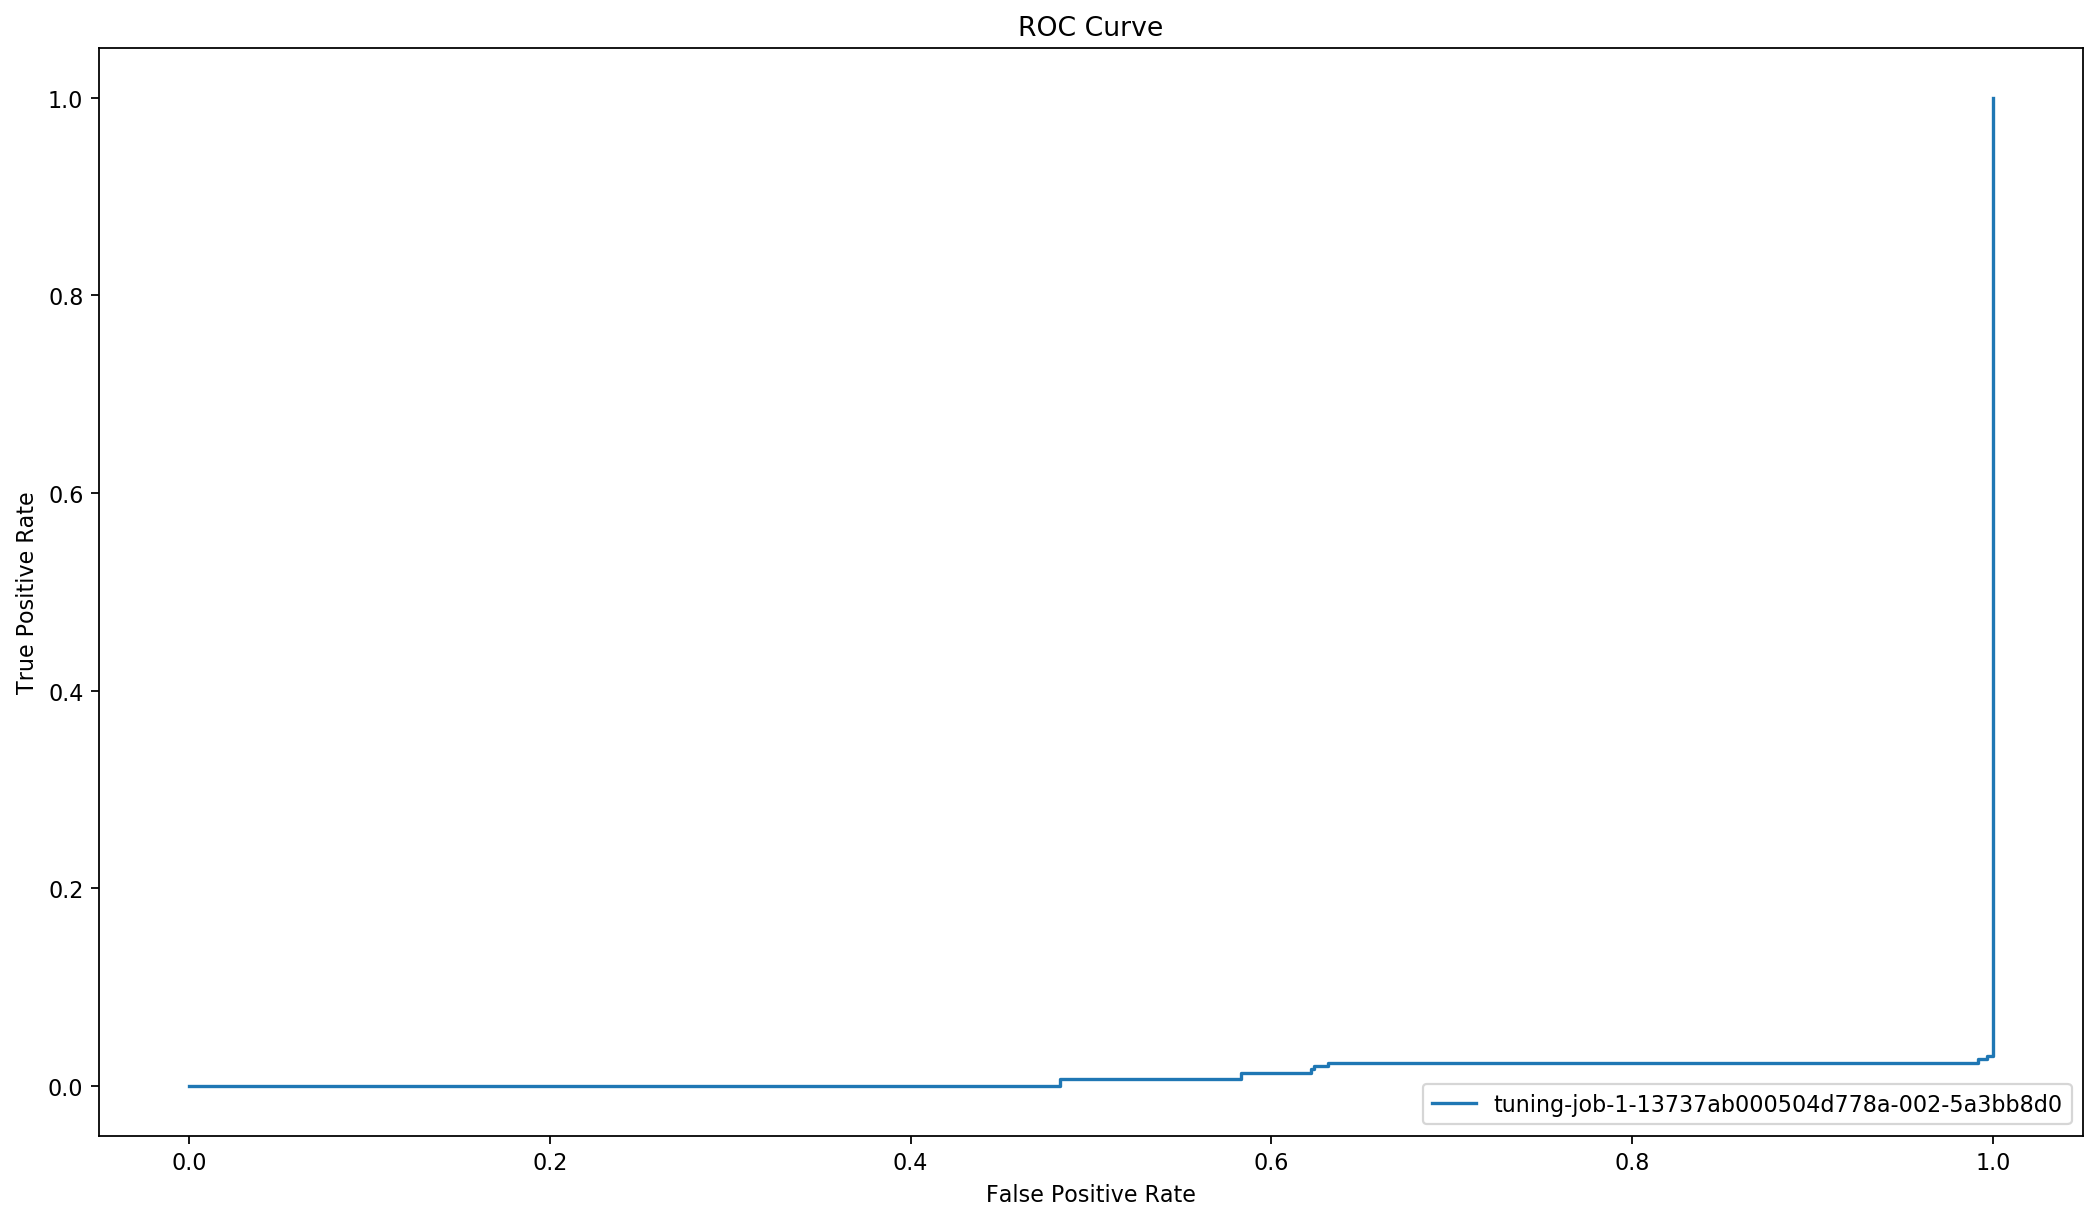

In [26]:
fpr_tpr = []
for prediction in predictions:
    fpr, tpr, _ = roc_curve(labels, prediction.loc[:,1])
    fpr_tpr.append(fpr)
    fpr_tpr.append(tpr)

plt.figure(num=None, figsize=(16, 9), dpi=160, facecolor='w', edgecolor='k')
plt.plot(*fpr_tpr)
plt.legend([candidate['CandidateName'] for candidate in candidates], loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

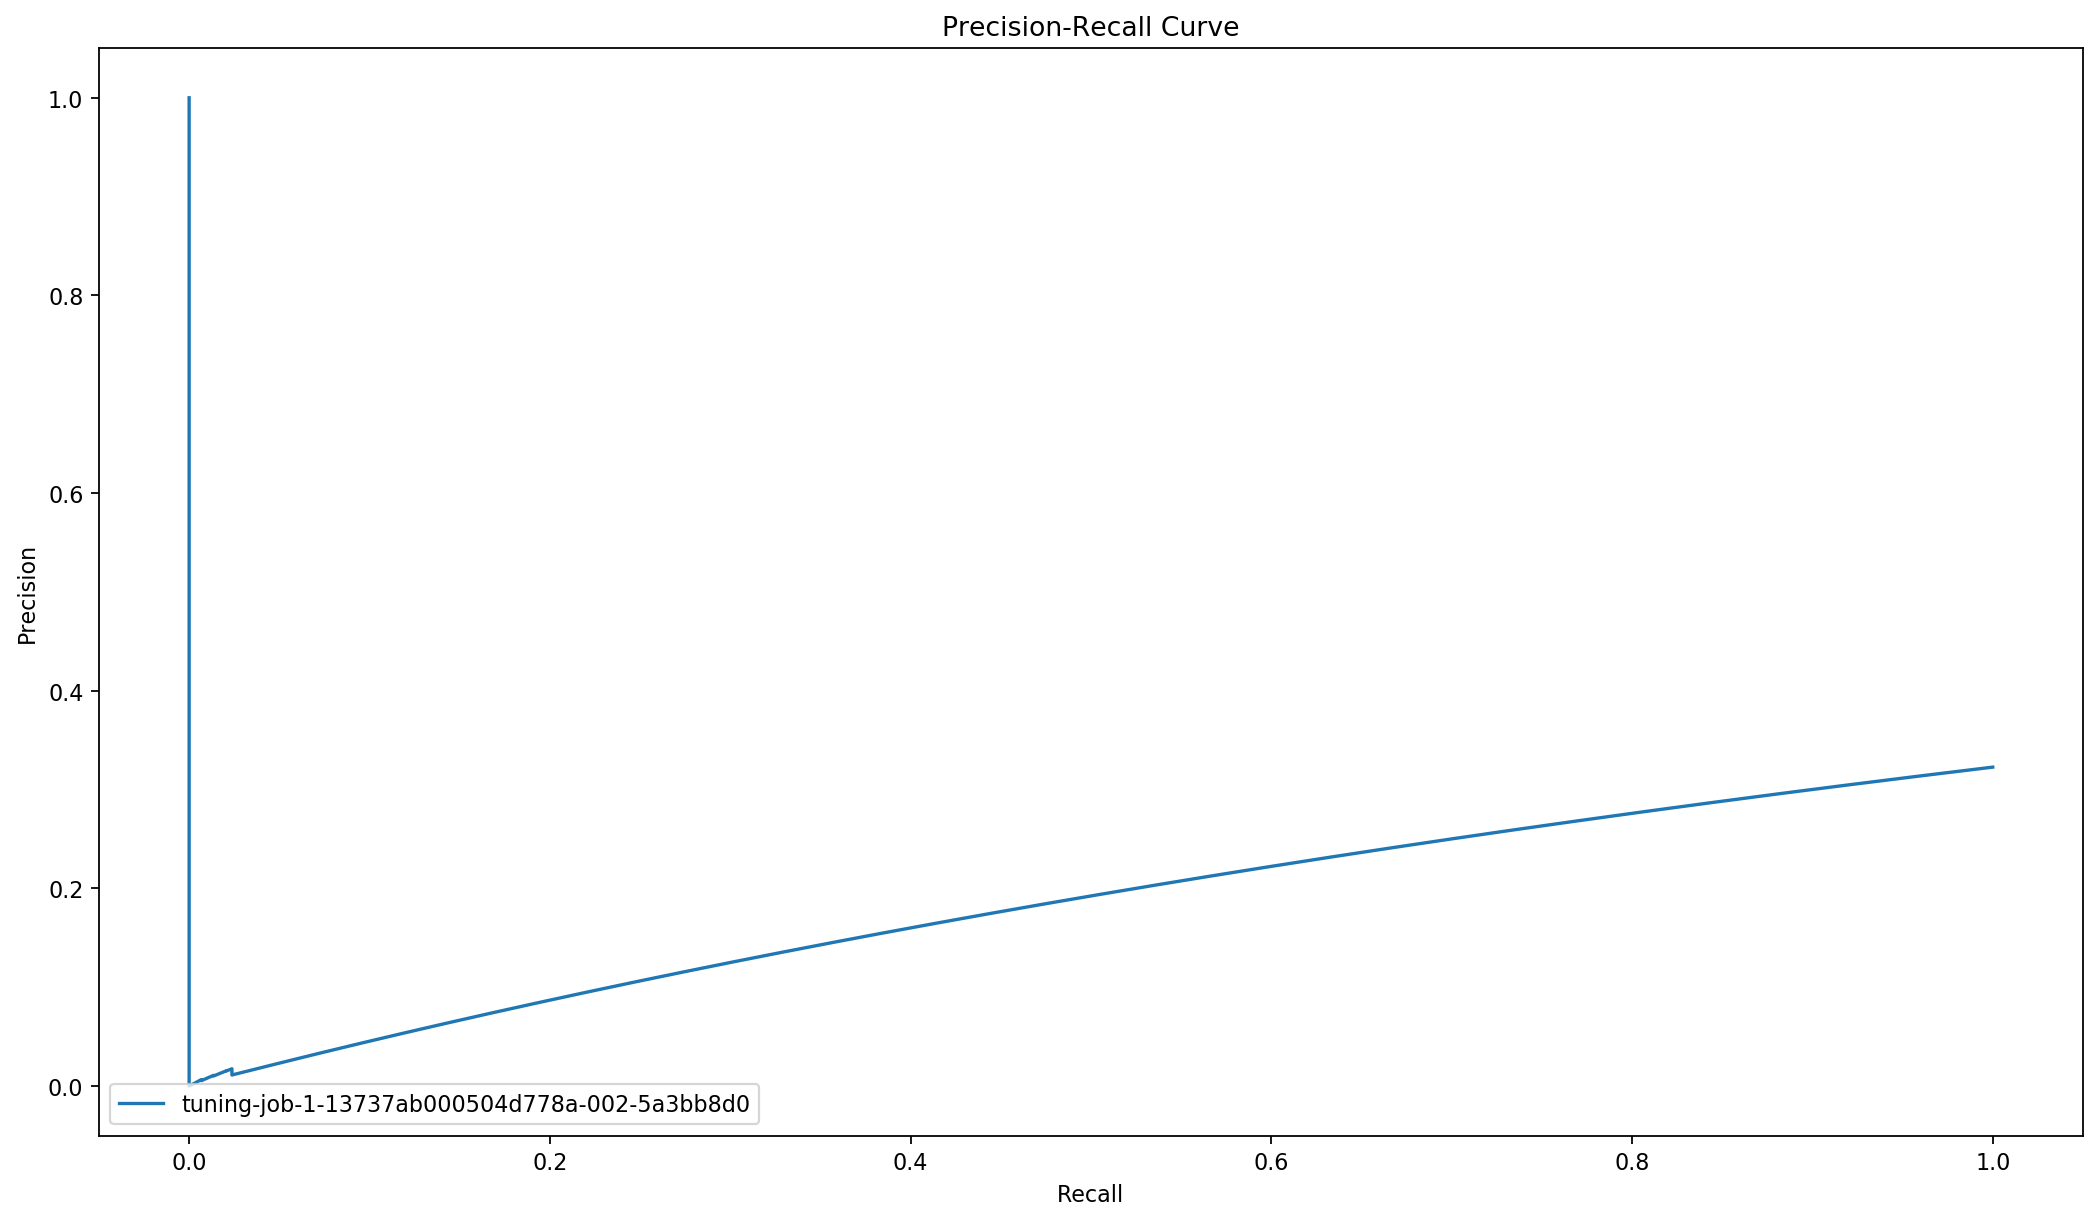

In [27]:
precision_recall = []
for prediction in predictions:
    precision, recall, _ = precision_recall_curve(labels, prediction.loc[:,1])
    precision_recall.append(recall)
    precision_recall.append(precision)

plt.figure(num=None, figsize=(16, 9), dpi=160, facecolor='w', edgecolor='k')
plt.plot(*precision_recall)
plt.legend([candidate['CandidateName'] for candidate in candidates], loc="lower left")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [28]:
target_min_precision = 0.75

best_recall = 0
best_candidate_idx = -1
best_candidate_threshold = -1
candidate_idx = 0
for prediction in predictions:
    precision, recall, thresholds = precision_recall_curve(labels, prediction.loc[:,1])
    threshold_idx = np.argmax(precision>=target_min_precision)
    if recall[threshold_idx] > best_recall:
        best_recall = recall[threshold_idx]
        best_candidate_threshold = thresholds[threshold_idx]
        best_candidate_idx = candidate_idx
    candidate_idx += 1

print("Best Candidate Name: {}".format(candidates[best_candidate_idx]['CandidateName']))
print("Best Candidate Threshold (Operation Point): {}".format(best_candidate_threshold))
print("Best Candidate Recall: {}".format(best_recall))

Best Candidate Name: tuning-job-1-13737ab000504d778a-002-5a3bb8d0
Best Candidate Threshold (Operation Point): -1
Best Candidate Recall: 0


In [29]:
prediction_default = predictions[best_candidate_idx].loc[:,0] == target_attribute_true_value
prediction_updated = predictions[best_candidate_idx].loc[:,1] >= best_candidate_threshold

# compare the updated predictions to Autopilot's default
from sklearn.metrics import precision_score, recall_score
print("Default Operating Point: recall={}, precision={}".format(recall_score(labels, prediction_default), precision_score(labels, prediction_default)))
print("Updated Operating Point: recall={}, precision={}".format(recall_score(labels, prediction_updated), precision_score(labels, prediction_updated)))

Default Operating Point: recall=1.0, precision=1.0
Updated Operating Point: recall=1.0, precision=0.3227571115973742


In [30]:
inference_response_keys

['predicted_label', 'probability']

In [31]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

predictor = automl.deploy(initial_instance_count=1,
                          instance_type='ml.m5.2xlarge',
                          candidate=candidates[best_candidate_idx],
                          inference_response_keys=inference_response_keys,
                          predictor_cls=Predictor,
                          serializer=CSVSerializer(),
                          deserializer=CSVDeserializer())

print("Created endpoint: {}".format(predictor.endpoint_name))


-------------!Created endpoint: sagemaker-sklearn-automl-2021-04-22-07-52-25-856


In [32]:
best_candidate_threshold

-1

In [33]:
prediction = predictor.predict(test_data_no_target.to_csv(sep=',', header=False, index=False))
prediction_df = pd.DataFrame(prediction, columns=inference_response_keys)
custom_predicted_labels = prediction_df.iloc[:,1].astype(float).values >= best_candidate_threshold
prediction_df['custom_predicted_label'] = custom_predicted_labels
prediction_df['custom_predicted_label'] = prediction_df['custom_predicted_label'].map({False: target_attribute_values[0], True: target_attribute_values[1]})
prediction_df

,predicted_label,probability,custom_predicted_label
0,13-17,0.735398530960083,25-34
1,13-17,0.7311930060386658,25-34
2,25-34,0.7197476029396057,25-34
3,13-17,0.7312238216400146,25-34
4,13-17,0.7319987416267395,25-34
...,...,...,...
909,25-34,0.7239765524864197,25-34
910,13-17,0.7353131175041199,25-34
911,25-34,0.7250945568084717,25-34
912,25-34,0.72602778673172,25-34


In [34]:
# s3 = boto3.resource('s3')
# s3_bucket = s3.Bucket(bucket)

# s3_bucket.objects.filter(Prefix=prefix).delete()

In [35]:
# for transformer in transformers:
#     transformer.delete_model()

# predictor.delete_endpoint()
# predictor.delete_model()

---
https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_applying_machine_learning/xgboost_direct_marketing/xgboost_direct_marketing_sagemaker.html

In [36]:
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(test_data['target_edad'], prediction_df['predicted_label'])

In [37]:
class_names = test_data['target_edad'].unique().tolist()
class_names

['13-17', '25-34']

[[619   0]
 [  0 295]]


<Figure size 432x288 with 0 Axes>

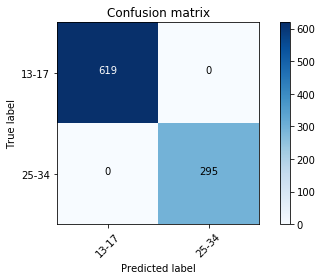

In [38]:
import itertools    
def plot_conf_mat(cm, classes, title, cmap = plt.cm.Blues):                                 
                                              
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(c_mat, classes=class_names, 
                          title='Confusion matrix')